In [1]:
import scanpy as sc
import scrublet as scr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.settings._vector_friendly = False

plt.rcParams["figure.dpi"] = 400
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = ["Arial"]
plt.rcParams["font.sans-serif"] = ["Arial"]

In [4]:
OUTPUT_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/analysis/neurons")
FIGURE_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/analysis/neurons/figures")

In [342]:
from datetime import datetime
def datestamp():
    return datetime.now().strftime("%Y%m%d")

def save_figure(fig, name, dpi=600, ext="pdf"):
    out = FIGURE_DIR / f"{name}_{datestamp()}.{ext}"
    pout = out.parent
    if not pout.exists():
        pout.mkdir(parents=True)
    fig.savefig(out, dpi=dpi)
    print(f"Saved to {out.name}")

from operator import add, sub
def fix_aspect_scatter_with_legend(fig):
    changed_ylims = None
    for ax in fig.get_axes():
        ax.set_aspect("equal", "box", share=True)
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        xmid, ymid = add(*xlims) / 2, add(*ylims) / 2
        xlen, ylen = sub(*xlims[::-1]), sub(*ylims[::-1])
        if xlen < ylen:
            diff = (ylen - xlen) / 2
            ax.set_xlim(xlims[0] - diff, xlims[1] + diff)
        else:
            diff = (xlen - ylen) / 2
            changed_ylims = (ylims[0] - diff, ylims[1] + diff)
            ax.set_ylim(*changed_ylims)
    fig.subplots_adjust(left=0, right=1)


def fix_aspect_scatter_with_cbar(fig):
    changed_ylims = None
    print(fig.get_children())
    for ax in fig.get_axes():
        ax.set_aspect("equal", "box", share=True)
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        xmid, ymid = add(*xlims) / 2, add(*ylims) / 2
        xlen, ylen = sub(*xlims[::-1]), sub(*ylims[::-1])
        if xlen < ylen:
            diff = (ylen - xlen) / 2
            ax.set_xlim(xlims[0] - diff, xlims[1] + diff)
        else:
            diff = (xlen - ylen) / 2
            changed_ylims = (ylims[0] - diff, ylims[1] + diff)
            ax.set_ylim(*changed_ylims)
        
    fig.subplots_adjust(left=0)

def marker_violins(
    adata,
    genes,
    cluster_key,
    palette,
    cluster_name="Cluster",
    filename=None,
    fig_width=2,
    scaling_factor=0.26,
    text=True
):
    L = len(genes)
    fig, axs = plt.subplots(L, 1, figsize=(fig_width, scaling_factor * L))
    violin_data = pd.DataFrame(adata[:, genes].layers["lognormed"].toarray(), columns=genes)
    violin_data[cluster_name] = adata.obs[cluster_key].values

    for k, (ax, gene) in enumerate(zip(axs.flat, genes)):
        sns.violinplot(
            data=violin_data,
            x=cluster_name,
            y=gene,
            palette=palette,
            ax=ax,
            inner=None,
            linewidth=0.4,
            scale="width",
            cut=0,
        )
        ax.set_ylabel(
            gene, rotation=0, ha="right", va="top", size="small", style="italic"
        )
        ax.set_yticks([])

        ax.set_ylim(0, ax.get_ylim()[1])

        if k < (L - 1):
            ax.set_xticks([])
            ax.set_xlabel(None)
            ax.xaxis.set_tick_params(which="both", tick1On=False, tick2On=False, size=0
                                    )
            ax.xaxis.label.set_visible(False)
        else:
            ax.xaxis.set_tick_params(labelsize="small")
        sns.despine(ax=ax, left=True)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
    if not text:
        remove_text(fig)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.04, wspace=0)
    if (filename is not None):
        save_figure(fig, filename)

## Load data

In [418]:
full = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-spread-2020-06-04T17-45-04.h5ad")
slc17a6 = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-slc17a6-final-2020-06-04T17-15-11.h5ad")
slc32a1 = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-slc32a1-final-2020-06-16T09-27-04.h5ad")

## Panel 1A

In [7]:
classification_palette = sns.xkcd_palette(
    ["bright red", "kelly green", "bright blue", "light grey"]
)

In [8]:
full.obs["classification_neuronal"] = full.obs.classification_neuronal_cluster_int.map({
    "0": "Chat", "1": "Slc32a1", "2": "Slc17a6", "-1": "non-neurons"
})
full.obs.classification_neuronal.cat.reorder_categories(
    ['Chat', 'Slc17a6', 'Slc32a1', 'non-neurons'], inplace=True
)

In [9]:
full.obsm["X_umap_rotate"] = full.obsm["X_umap"] @ np.array([[0, -1],[1, 0]])

Saved to panel_1A_20200614.pdf


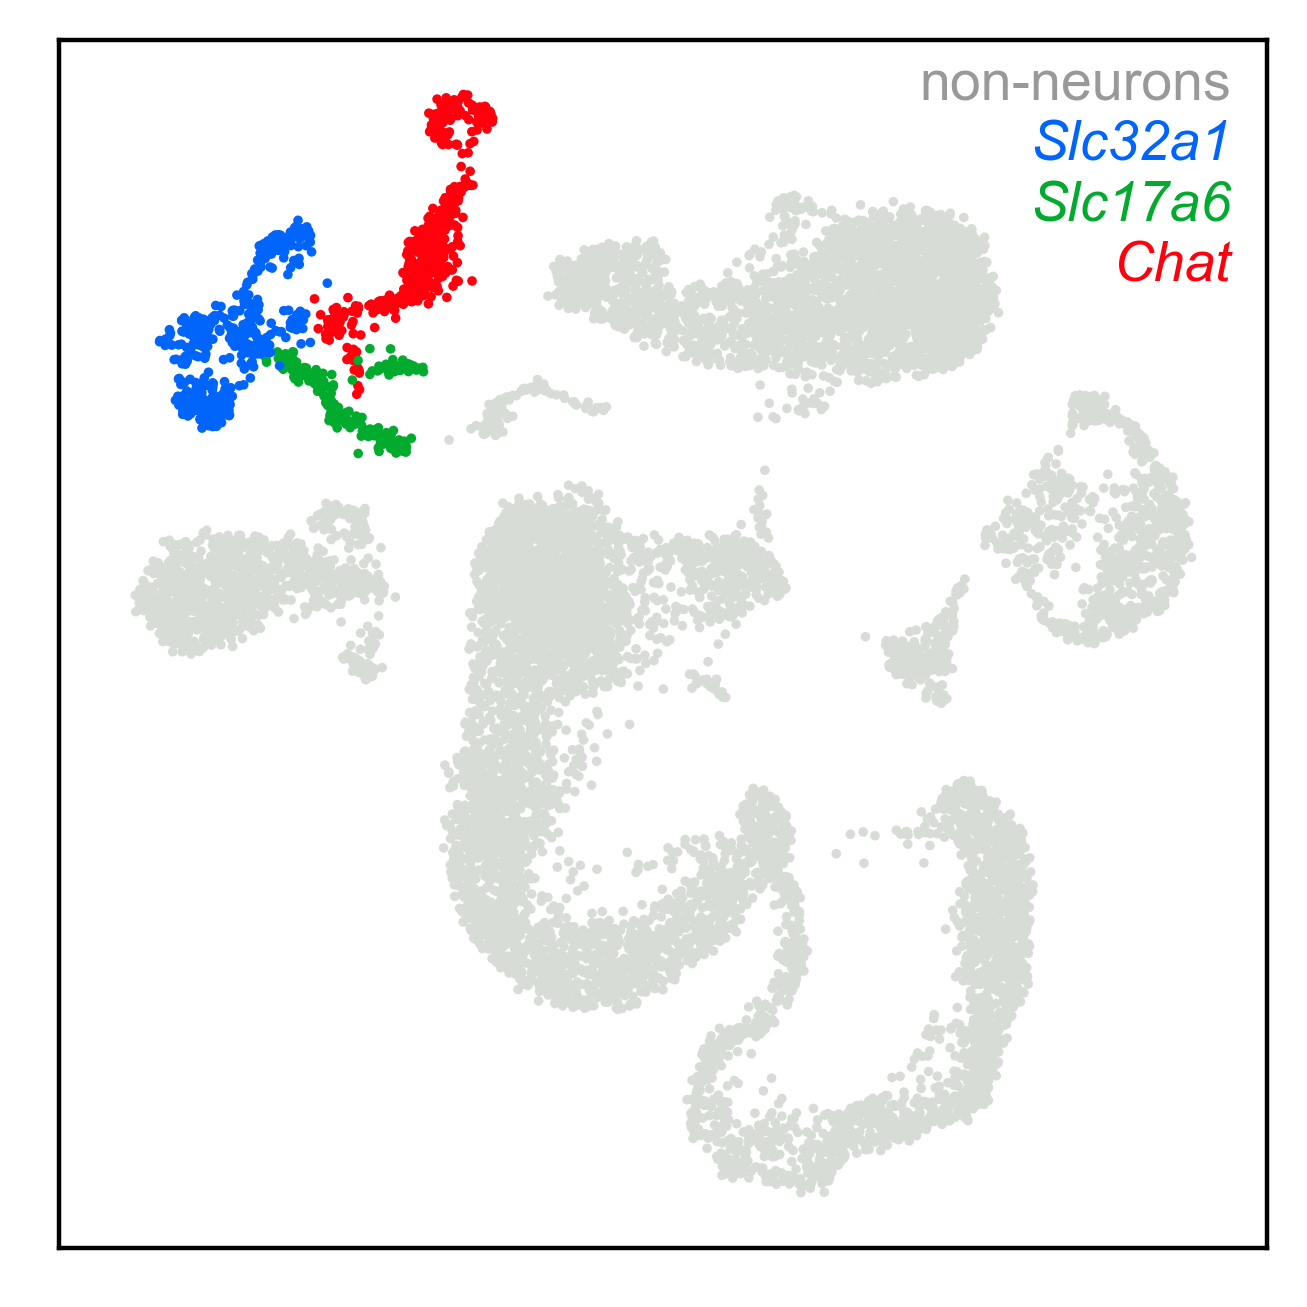

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.scatter(
    full, basis="umap_rotate", color="classification_neuronal", size=12,
    ax=ax, show=False, 
    palette=classification_palette,
    title="", legend_loc="none",
)
ax.set_xlabel("")
ax.set_ylabel("")
for k, (label, color) in enumerate(zip(("Chat", "Slc17a6", "Slc32a1", "non-neurons"), classification_palette)):
    ax.text(
        0.97, 0.8+(k*0.05), label, 
        color=color if k < 3 else "0.6", 
        fontdict=dict([("style", "italic" if k < 3 else "normal")]), 
        transform=ax.transAxes, ha="right",
    )
fix_aspect_scatter_with_legend(fig)
save_figure(fig, "panel_1A")

## Panels 1B top and bottom

In [11]:
slc17a6.obs["friendly_cluster"] = slc17a6.obs.cluster.map({
    "3": "1", 
    "4": "2",
    "5": "3",
    "6": "4",
    "7": "5",
    "1": "6",
    "2": "7",
    "8": "8",
}).astype("category")
slc17a6.obs.friendly_cluster.cat.reorder_categories(list("12345678"), inplace=True)

In [12]:
slc17a6.obs["friendly_cluster_comb"] = slc17a6.obs.friendly_cluster.map({
    "1": "1",
    "2": "2",
    "3": "3", "4": "3", "5": "3",
    "6": "4", "7": "4",
    "8": "5"
}).astype("category")
slc17a6.obs.friendly_cluster_comb.cat.reorder_categories(list("12345"), inplace=True)

In [13]:
green_palette = [sns.desaturate(c, 0.7) for c in sns.mpl_palette("Greens", 5)[1:]]
blue_palette = [sns.desaturate(c, 0.7) for c in sns.mpl_palette("Blues", 6)[1:]]

In [14]:
def move_label_text(ax, key, dx=None, dy=None):
    c = ax.get_children()
    t = [c for c in ax.get_children() if isinstance(c, plt.Text) and (c.get_text() == key)][0]
    x, y= t.get_position()
    if dx:
        t.set_x(x+dx)
    if dy:
        t.set_y(y+dy)

Saved to panel_1B_1_20200614.pdf


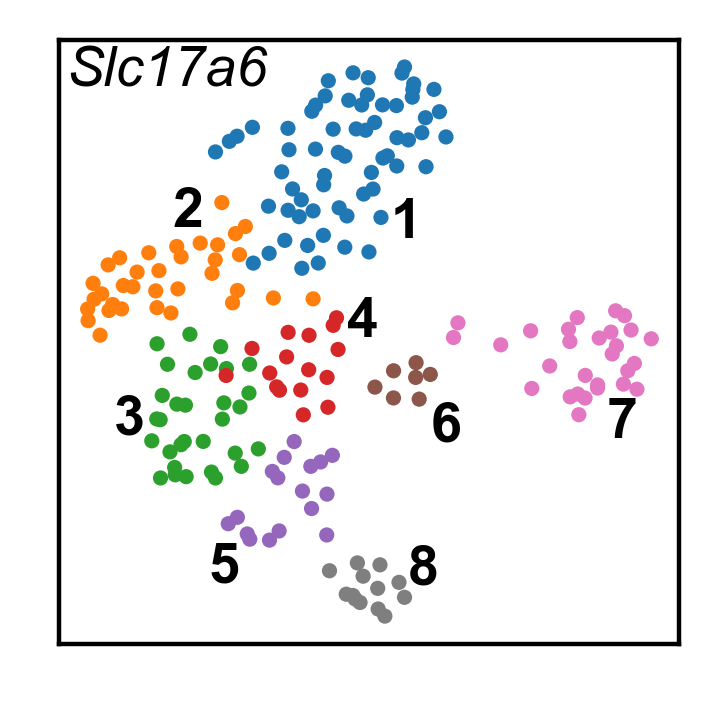

In [15]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(
    slc17a6, color="friendly_cluster", 
    ax=ax, show=False, size=30,
    palette=sns.mpl_palette("tab10", 10),
    #palette=blue_palette,
    title="", legend_loc="on data"
)
ax.text(0.01, 0.99, "Slc17a6", va="top", fontdict=dict(style="italic"), transform=ax.transAxes)
move_label_text(ax, "1", dx=1, dy=-1.5)
move_label_text(ax, "2", dx=0.5, dy=1.5)
move_label_text(ax, "3", dx=-1., dy=0)
move_label_text(ax, "4", dx=1, dy=1)
move_label_text(ax, "5", dx=-1, dy=-1.5)
move_label_text(ax, "6", dx=0.5, dy=-1.)
move_label_text(ax, "7", dx=0.5, dy=-1.5)
move_label_text(ax, "8", dx=1, dy=0.5)
ax.set_xlabel(""); ax.set_ylabel("")
save_figure(fig, "panel_1B_1")

Saved to panel_1B_1-clusters-combined_20200614.pdf


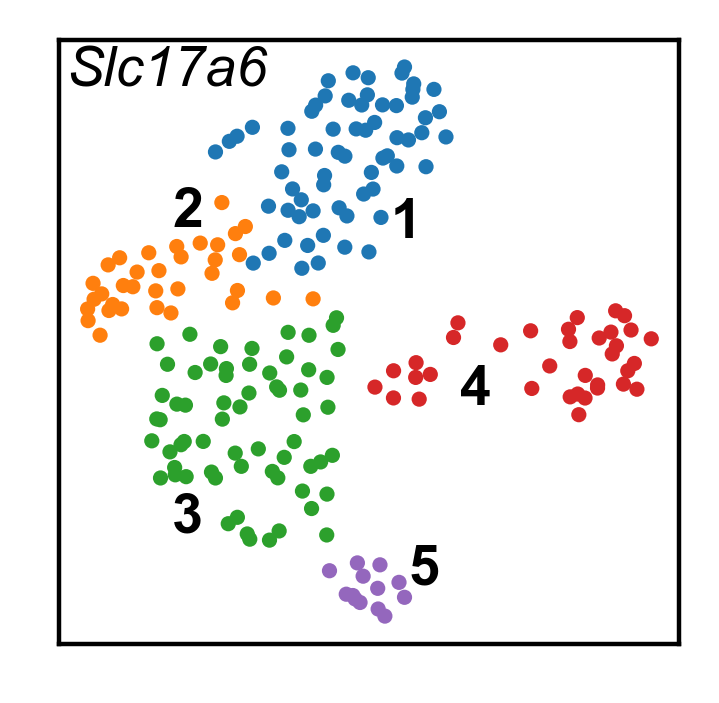

In [16]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(
    slc17a6, color="friendly_cluster_comb", 
    ax=ax, show=False, size=30,
    palette=sns.mpl_palette("tab10", 10),
    #palette=blue_palette,
    title="", legend_loc="on data"
)
ax.text(0.01, 0.99, "Slc17a6", va="top", fontdict=dict(style="italic"), transform=ax.transAxes)
move_label_text(ax, "1", dx=1, dy=-1.5)
move_label_text(ax, "2", dx=0.5, dy=1.5)
move_label_text(ax, "3", dx=-1, dy=-2)
move_label_text(ax, "4", dx=-1.7, dy=-0.5)
move_label_text(ax, "5", dx=1, dy=0.5)
ax.set_xlabel(""); ax.set_ylabel("")
save_figure(fig, "panel_1B_1-clusters-combined")

In [17]:
slc17a6_markers = "Stmn4 Phox2b Gal Nmb Gpr4 Kcnk5  Tac1 Chat  Th".split()

Saved to panel_1B_2_20200614.pdf


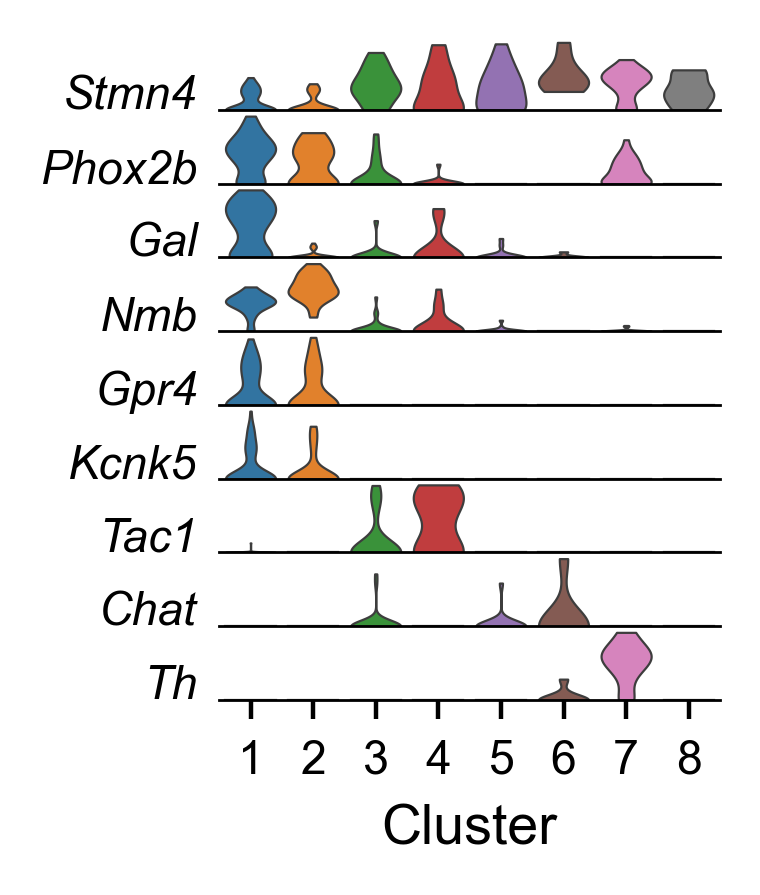

In [18]:
marker_violins(slc17a6, slc17a6_markers, "friendly_cluster", sns.mpl_palette("tab10", 10), filename="panel_1B_2")

Saved to panel_1B_2-clusters-combined_20200614.pdf


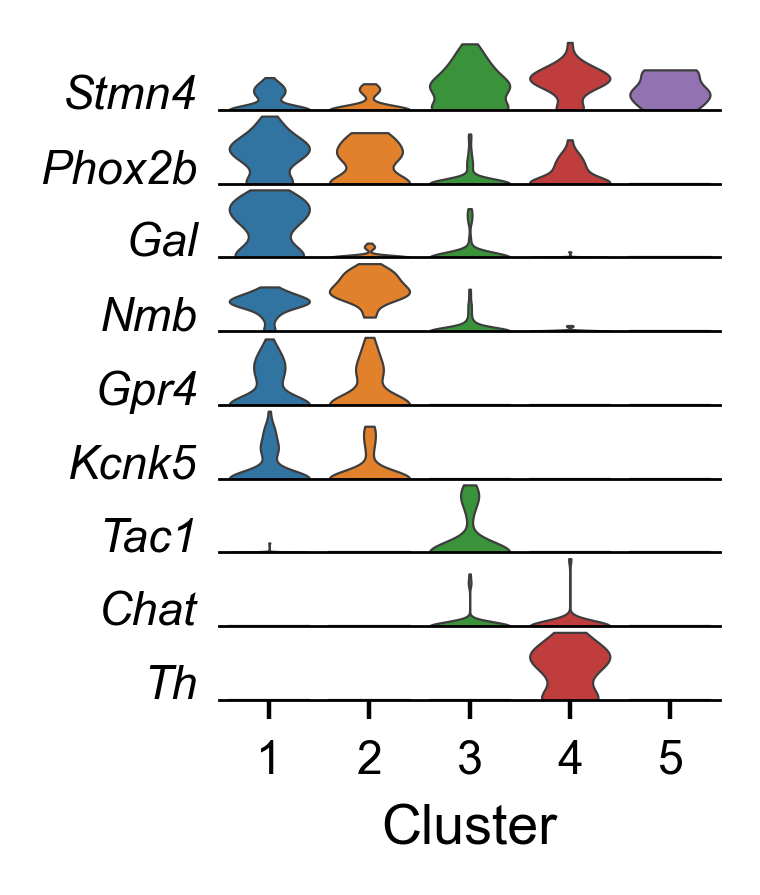

In [19]:
marker_violins(slc17a6, slc17a6_markers, "friendly_cluster_comb", sns.mpl_palette("tab10", 10), 
               filename="panel_1B_2-clusters-combined")

## Panels 1C top and bottom

In [423]:
slc32a1.obs["friendly_cluster"] = slc32a1.obs.cluster.map({
    "2": "1", 
    "3": "2",
    "4": "3",
    "1": "4",
    "7": "5",
    "6": "6",
    "5": "7",
}).astype("category")
slc32a1.obs.friendly_cluster.cat.reorder_categories(list("1234567"), inplace=True)

Saved to panel_1C_1_20200616.pdf


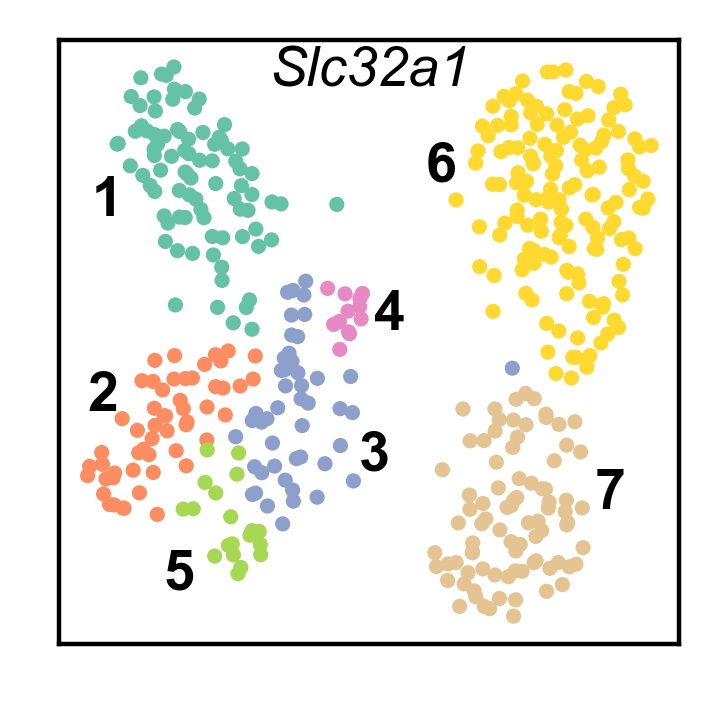

In [446]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(
    slc32a1, color="friendly_cluster", 
    ax=ax, show=False, size=30,
    palette=sns.mpl_palette("Set2", 10),
    #palette=sns.mpl_palette("Blues", 6)[1:],
    title="", legend_loc="on data"
)
ax.text(0.5, 0.99, "Slc32a1", ha="center", va="top", fontdict=dict(style="italic"), transform=ax.transAxes)
move_label_text(ax, "1", dx=-1.5, dy=-0.5)
move_label_text(ax, "2", dx=-1, dy=0.5)
move_label_text(ax, "3", dx=1.5, dy=-0.75)
move_label_text(ax, "4", dx=0.75, dy=0)
move_label_text(ax, "5", dx=-1, dy=-0.75)
move_label_text(ax, "6", dx=-2.25, dy=0.5)
move_label_text(ax, "7", dx=1.75, dy=0.5)
ax.set_xlabel(""); ax.set_ylabel("")
save_figure(fig, "panel_1C_1")

In [456]:
slc32a1_markers = "Lamp5 Slc6a5 Cck Dmbx1 Ndnf Sst Nos1 Calb2 Pvalb Reln Fst".split()

Saved to panel_1C_2_20200616.pdf


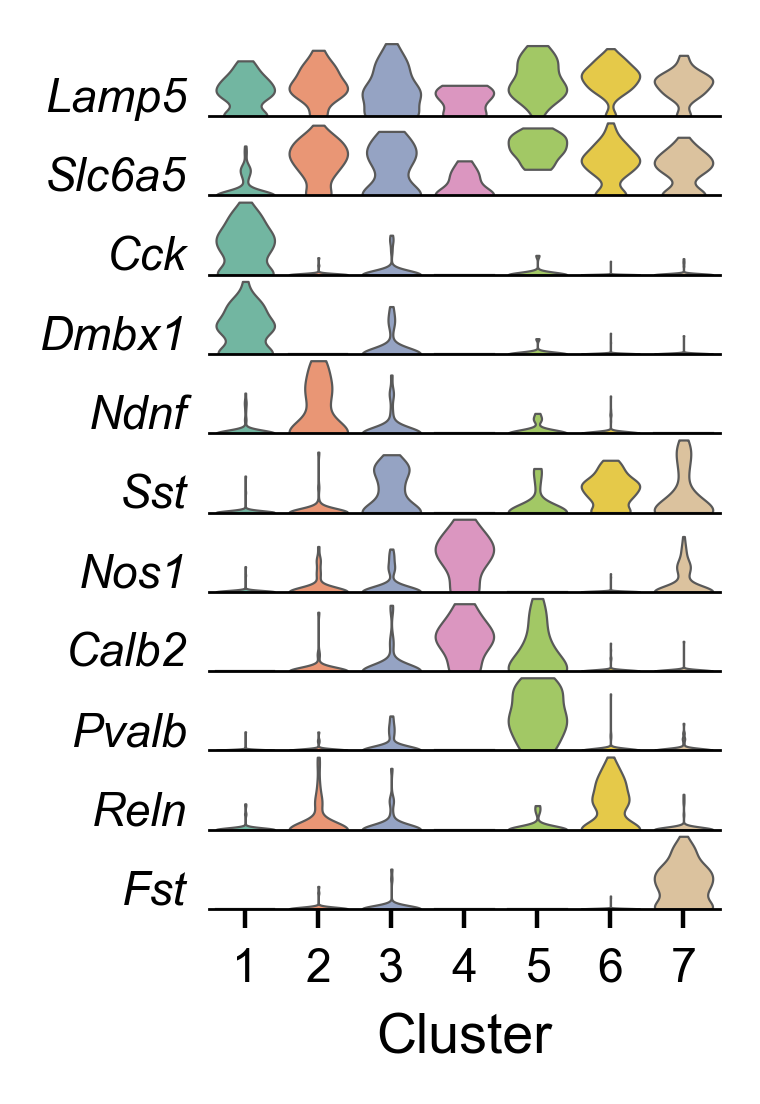

In [457]:
marker_violins(
    slc32a1, slc32a1_markers, "friendly_cluster", 
    sns.mpl_palette("Set2", 10), 
    filename="panel_1C_2"
)

# Figures without doublets/weird cells

In [454]:
#slc17a6_nodub = slc17a6[~slc17a6.obs.friendly_cluster_comb.isin(["5"])].copy()
slc32a1_nodub = slc32a1[~slc32a1.obs.visible_doublet].copy()

Saved to panel_1B_1-clusters-combined-nodub_20200614.pdf


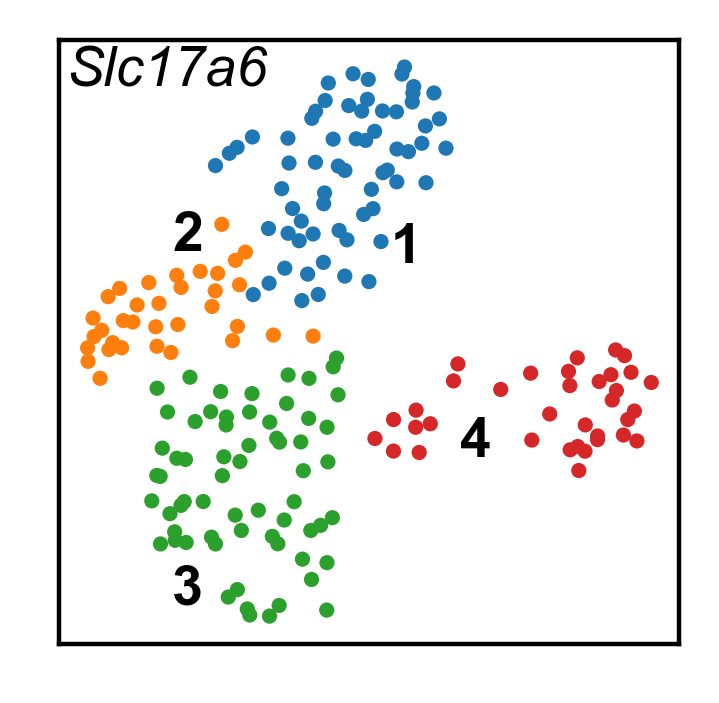

In [25]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(
    slc17a6_nodub, color="friendly_cluster_comb", 
    ax=ax, show=False, size=30,
    palette=sns.mpl_palette("tab10", 10),
    #palette=blue_palette,
    title="", legend_loc="on data"
)
ax.text(0.01, 0.99, "Slc17a6", va="top", fontdict=dict(style="italic"), transform=ax.transAxes)
move_label_text(ax, "1", dx=1, dy=-1.5)
move_label_text(ax, "2", dx=0.5, dy=1.5)
move_label_text(ax, "3", dx=-1, dy=-2)
move_label_text(ax, "4", dx=-1.7, dy=-0.5)
ax.set_xlabel(""); ax.set_ylabel("")
save_figure(fig, "panel_1B_1-clusters-combined-nodub")

Saved to panel_1C_1-nodub_20200616.pdf


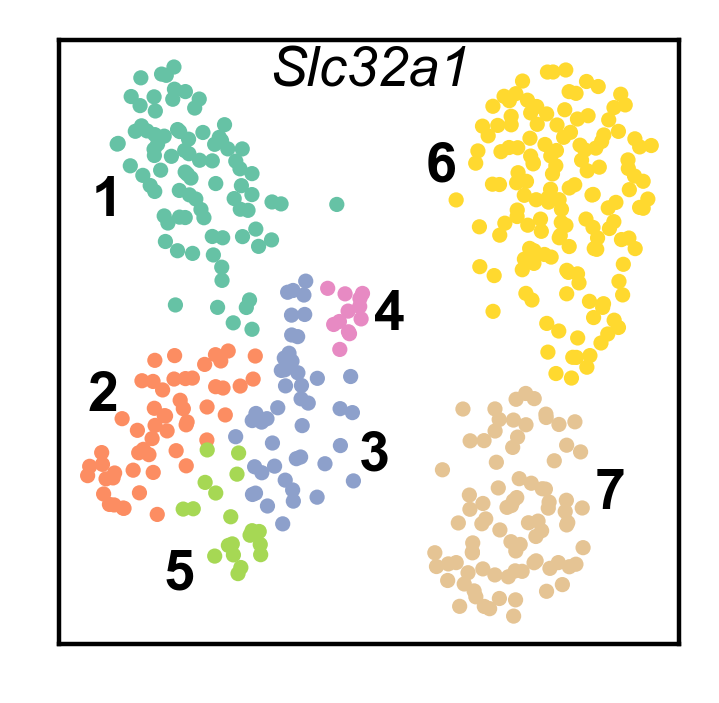

In [455]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(
    slc32a1_nodub, color="friendly_cluster", 
    ax=ax, show=False, size=30,
    palette=sns.mpl_palette("Set2", 10),
    #palette=sns.mpl_palette("Blues", 6)[1:],
    title="", legend_loc="on data"
)
ax.text(0.5, 0.99, "Slc32a1", ha="center", va="top", fontdict=dict(style="italic"), transform=ax.transAxes)
move_label_text(ax, "1", dx=-1.5, dy=-0.5)
move_label_text(ax, "2", dx=-1, dy=0.5)
move_label_text(ax, "3", dx=1.5, dy=-0.75)
move_label_text(ax, "4", dx=0.75, dy=0)
move_label_text(ax, "5", dx=-1, dy=-0.75)
move_label_text(ax, "6", dx=-2.25, dy=0.5)
move_label_text(ax, "7", dx=1.75, dy=0.5)
ax.set_xlabel(""); ax.set_ylabel("")
save_figure(fig, "panel_1C_1-nodub")

# Table reporting

In [27]:
dm1 = sc.read(OUTPUT_DIR / "h5ad" / "DM18006-raw-2020-05-30T16-08-16.h5ad")
dm2 = sc.read(OUTPUT_DIR / "h5ad" / "DM18008-raw-2020-05-30T16-08-32.h5ad")

In [28]:
slc17a6.obs[
(slc17a6[:, "Phox2b"].X > 0)
].groupby("library_id").size()

library_id
DM18006    29
DM18008    57
dtype: int64

In [377]:
3767 + 10241

14008

In [29]:
print("Raw cells 1", dm1.shape[0])
print("Raw cells 2", dm2.shape[0])
print("Total cells", full.shape[0])
print("Total neurons", (full.obs.classification_neuronal_cluster_int.astype(int) >= 0).sum())
print("Raw chat+ neurons", (full.obs.classification_neuronal == "Chat").sum())
print("Raw inhib neurons", (full.obs.classification_neuronal == "Slc32a1").sum())
print("Raw excit neurons", (full.obs.classification_neuronal == "Slc17a6").sum())
print("Final Excitatory ", slc17a6_nodub.shape[0])
print("Final Inhibitory ", slc32a1_nodub.shape[0])
print("Final Phox2b+ ", (slc17a6_nodub[:, "Phox2b"].X > 0).sum())

Raw cells 1 3767
Raw cells 2 10241
Total cells 11810
Total neurons 1134
Raw chat+ neurons 460
Raw inhib neurons 464
Raw excit neurons 210
Final Excitatory  197
Final Inhibitory  445
Final Phox2b+  86


In [30]:
slc17a6_nodub.obs.groupby("library_id").size()

library_id
DM18006     52
DM18008    145
dtype: int64

In [31]:
slc32a1_nodub.obs.groupby("library_id").size()

library_id
DM18006     98
DM18008    347
dtype: int64

## QC

In [32]:
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0


In [33]:
merged_raw = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-merged-2020-05-30T16-09-24.h5ad")

In [36]:
merged_raw.obs.groupby("library_id").size()

library_id
DM18006    3345
DM18008    9054
dtype: int64

In [37]:
merged_raw.shape

(12399, 15923)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Saved to panel_S1A_20200614.pdf


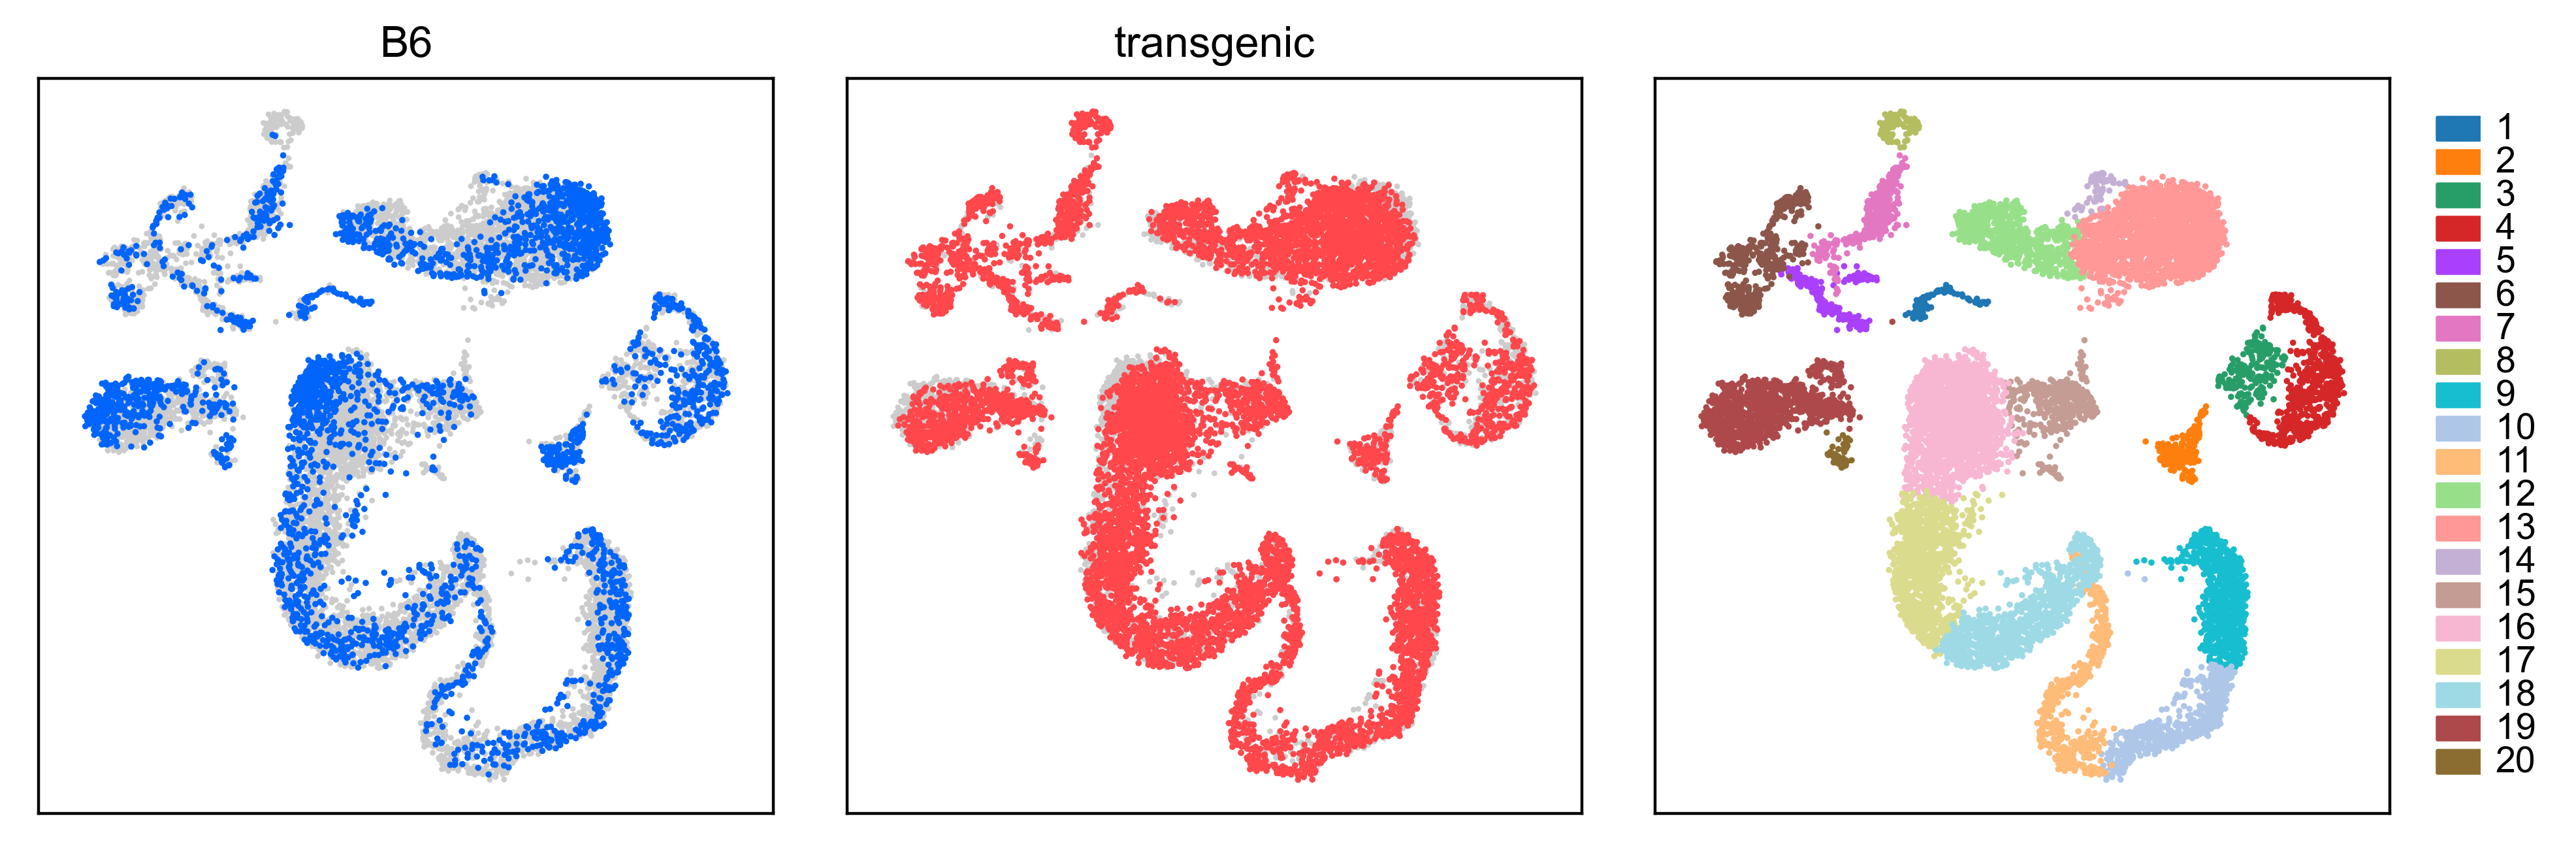

In [364]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
for ax in (ax1, ax2):
    sc.pl.scatter(
        full, basis="umap_rotate", size=10, ax=ax, show=False, title="", legend_loc="none", color="0.8"
    )
sc.pl.scatter(
    full[full.obs.background=="b6"], basis="umap_rotate", color="background", size=12,
    ax=ax1, show=False, 
    palette=[sns.xkcd_rgb["bright blue"]],
    title="B6", legend_loc="none"
)
sc.pl.scatter(
    full[full.obs.background=="transgenic"], basis="umap_rotate", color="background", size=12,
    ax=ax2, show=False, 
    palette=[sns.xkcd_rgb["light red"]],
    title="transgenic", legend_loc="none"
)
sc.pl.scatter(
    full, basis="umap_rotate", color="cluster", size=12,
    ax=ax3, show=False, palette=sc.pl.palettes.default_20,
    title="", legend_loc="none", 
)

leg = ax3.legend(
    handles=[
        ax.scatter([], [], color=color, marker=[(1,0.5), (-1, 0.5), (-1, -0.5), (1, -0.5)]) 
        for color in sc.pl.palettes.default_20
    ], 
    labels=full.obs.cluster.cat.categories.tolist(),
    ncol=1, frameon=False, bbox_to_anchor=(1, 0.5), loc="center left", 
    handletextpad=0, labelspacing=0, markerscale=2
)

for ax in (ax1, ax2, ax3):
    ax.set_xlabel("")
    ax.set_ylabel("")
fix_aspect_scatter_with_legend(fig)
fig.subplots_adjust(wspace=0.1, right=0.9)
save_figure(fig, "panel_S1A")

In [110]:
sc.tl.rank_genes_groups(full, groupby="cluster", use_raw=False, method="wilcoxon",)

ranking genes


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:47)


Saved to panel_S1B_20200614.pdf


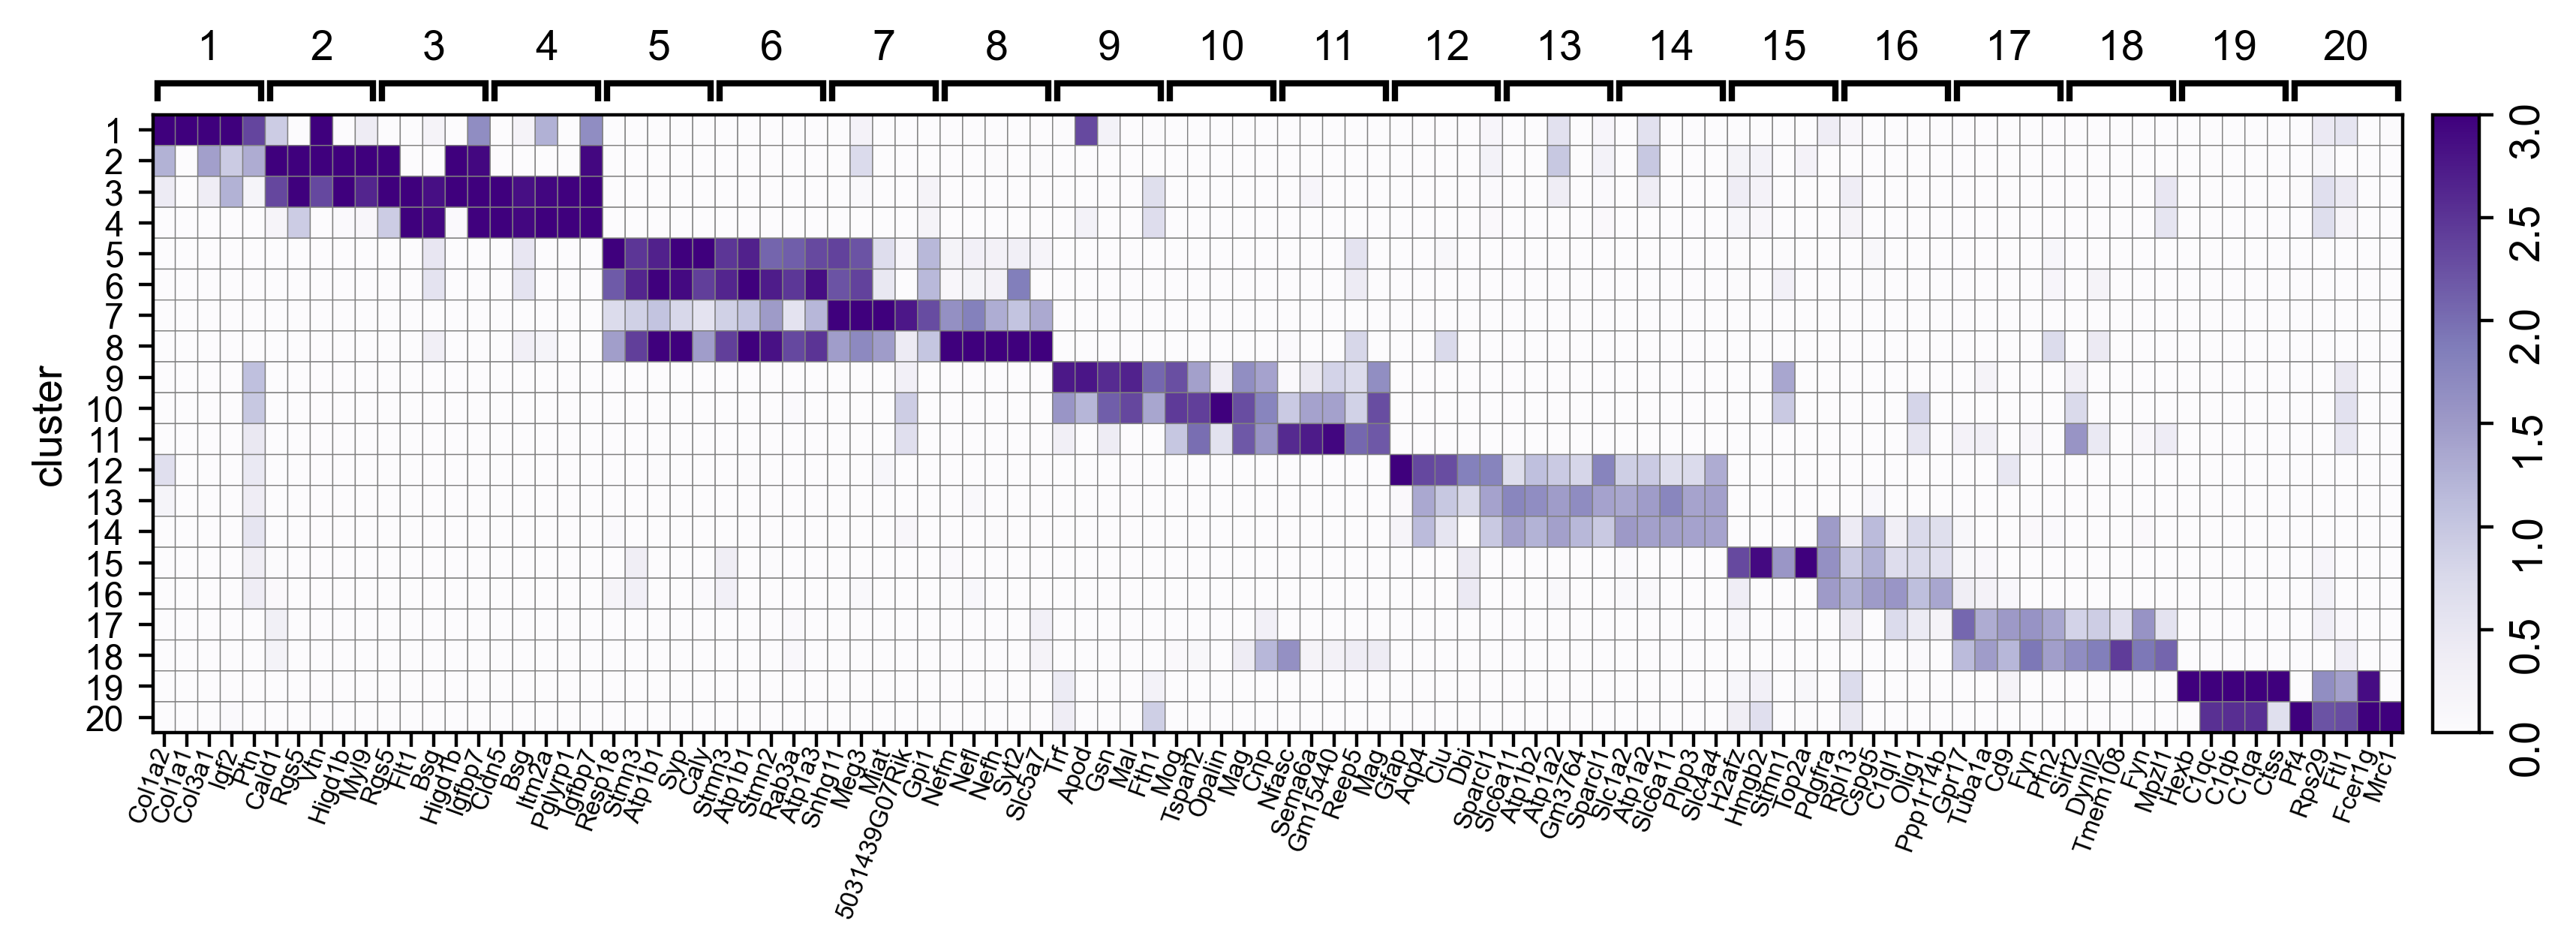

In [366]:
sc.pl.rank_genes_groups_matrixplot(
    full, show=False, groupby="cluster", dendrogram=False, n_genes=5, cmap="Purples", vmax=3, vmin=0, use_raw=False, 
    figsize=(10, 3),
)
fig = plt.gcf()
heatmap_ax = fig.get_children()[1]
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), rotation=70, 
                           ha="right", size=6, rotation_mode="anchor", va="center");
heatmap_ax.tick_params(axis="x", pad=0)
cbar_ax = fig.get_children()[-1]
bbox = cbar_ax.get_position()
bbox.y1 /= 2
cbar_ax.set_position(bbox)
cbar_ax.tick_params(axis="y", rotation=90)
fig.subplots_adjust(bottom=0.25)
save_figure(fig, "panel_S1B")

In [206]:
counts = full.obs.groupby((["cluster", "background"])).size()

In [209]:
counts = counts.reset_index()
counts.columns = ["cluster", "background", "count"]

Saved to panel_S1C_20200614.pdf


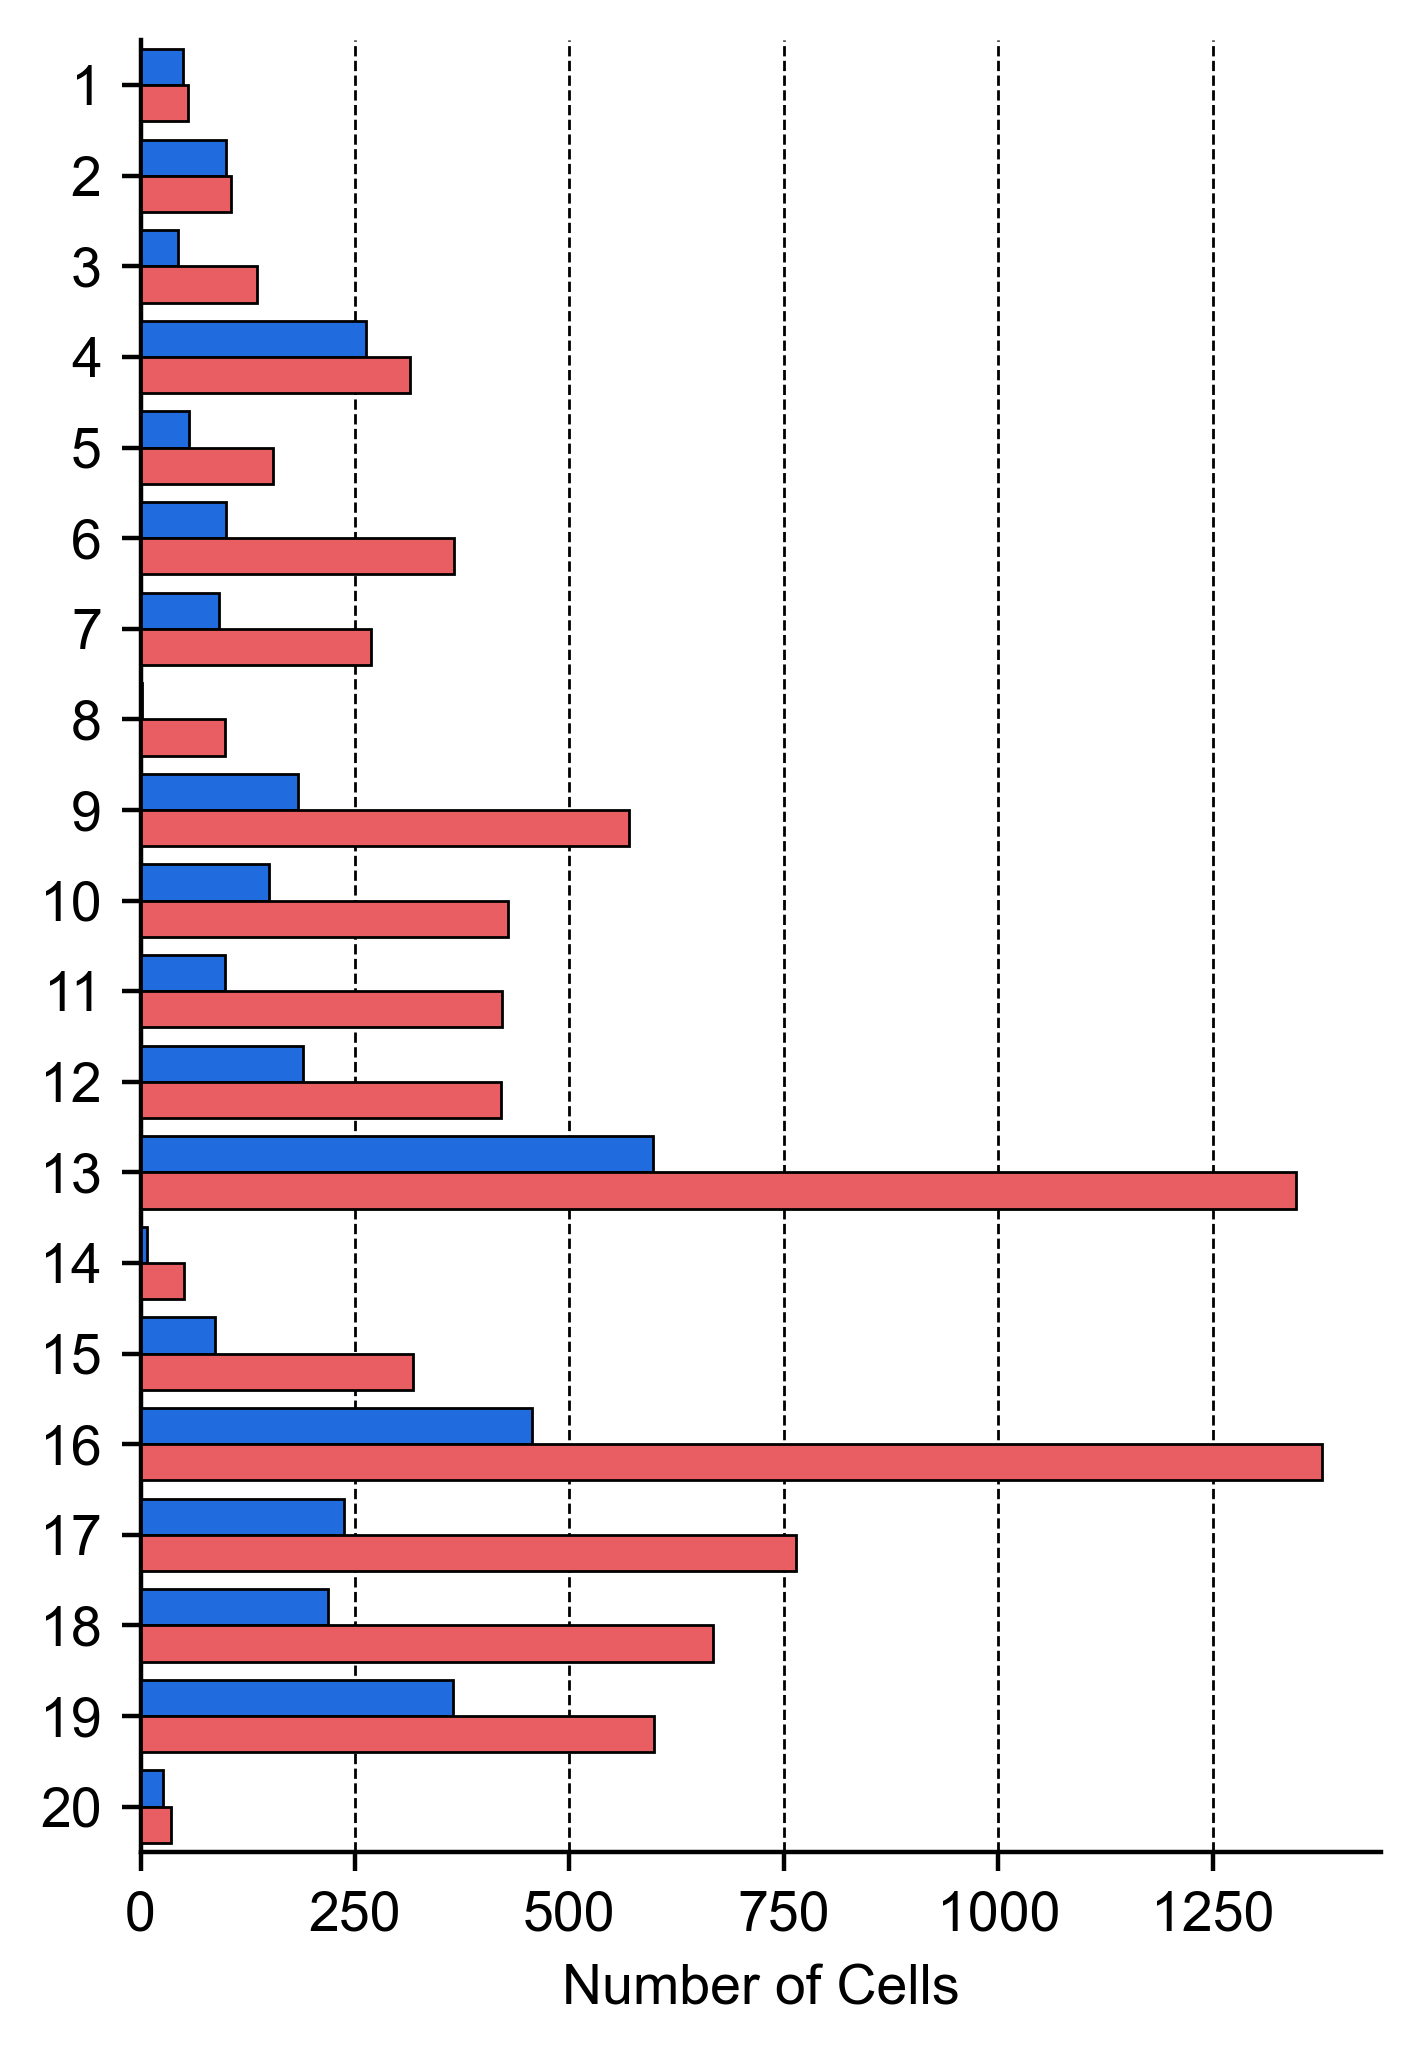

In [369]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.barplot(
    data=counts, orient="horizontal", y="cluster", x="count", hue="background", 
    palette=sns.xkcd_palette(["bright blue", "light red"]), zorder=10, edgecolor="k", linewidth=0.5
)
ax.get_children()[-2].remove()
ax.grid(axis="x", zorder=-10, ls="--", color="k", lw=0.5)
ax.set_xlabel("Number of Cells")
ax.set_ylabel("")
sns.despine(fig, ax)
save_figure(fig, "panel_S1C")

In [239]:
umis = full.obs[["cluster", "background", "total_counts"]]

In [243]:
umis.head()

cluster background  total_counts
AAACCTGAGGACATTA-1-0       9         b6        2060.0
AAACCTGAGTACGCGA-1-0      18         b6        2511.0
AAACCTGAGTGTACGG-1-0      16         b6        2858.0
AAACCTGGTATAGGGC-1-0      13         b6        3295.0
AAACCTGGTCCCTACT-1-0      16         b6        2922.0

Saved to panel_S1D_20200614.pdf


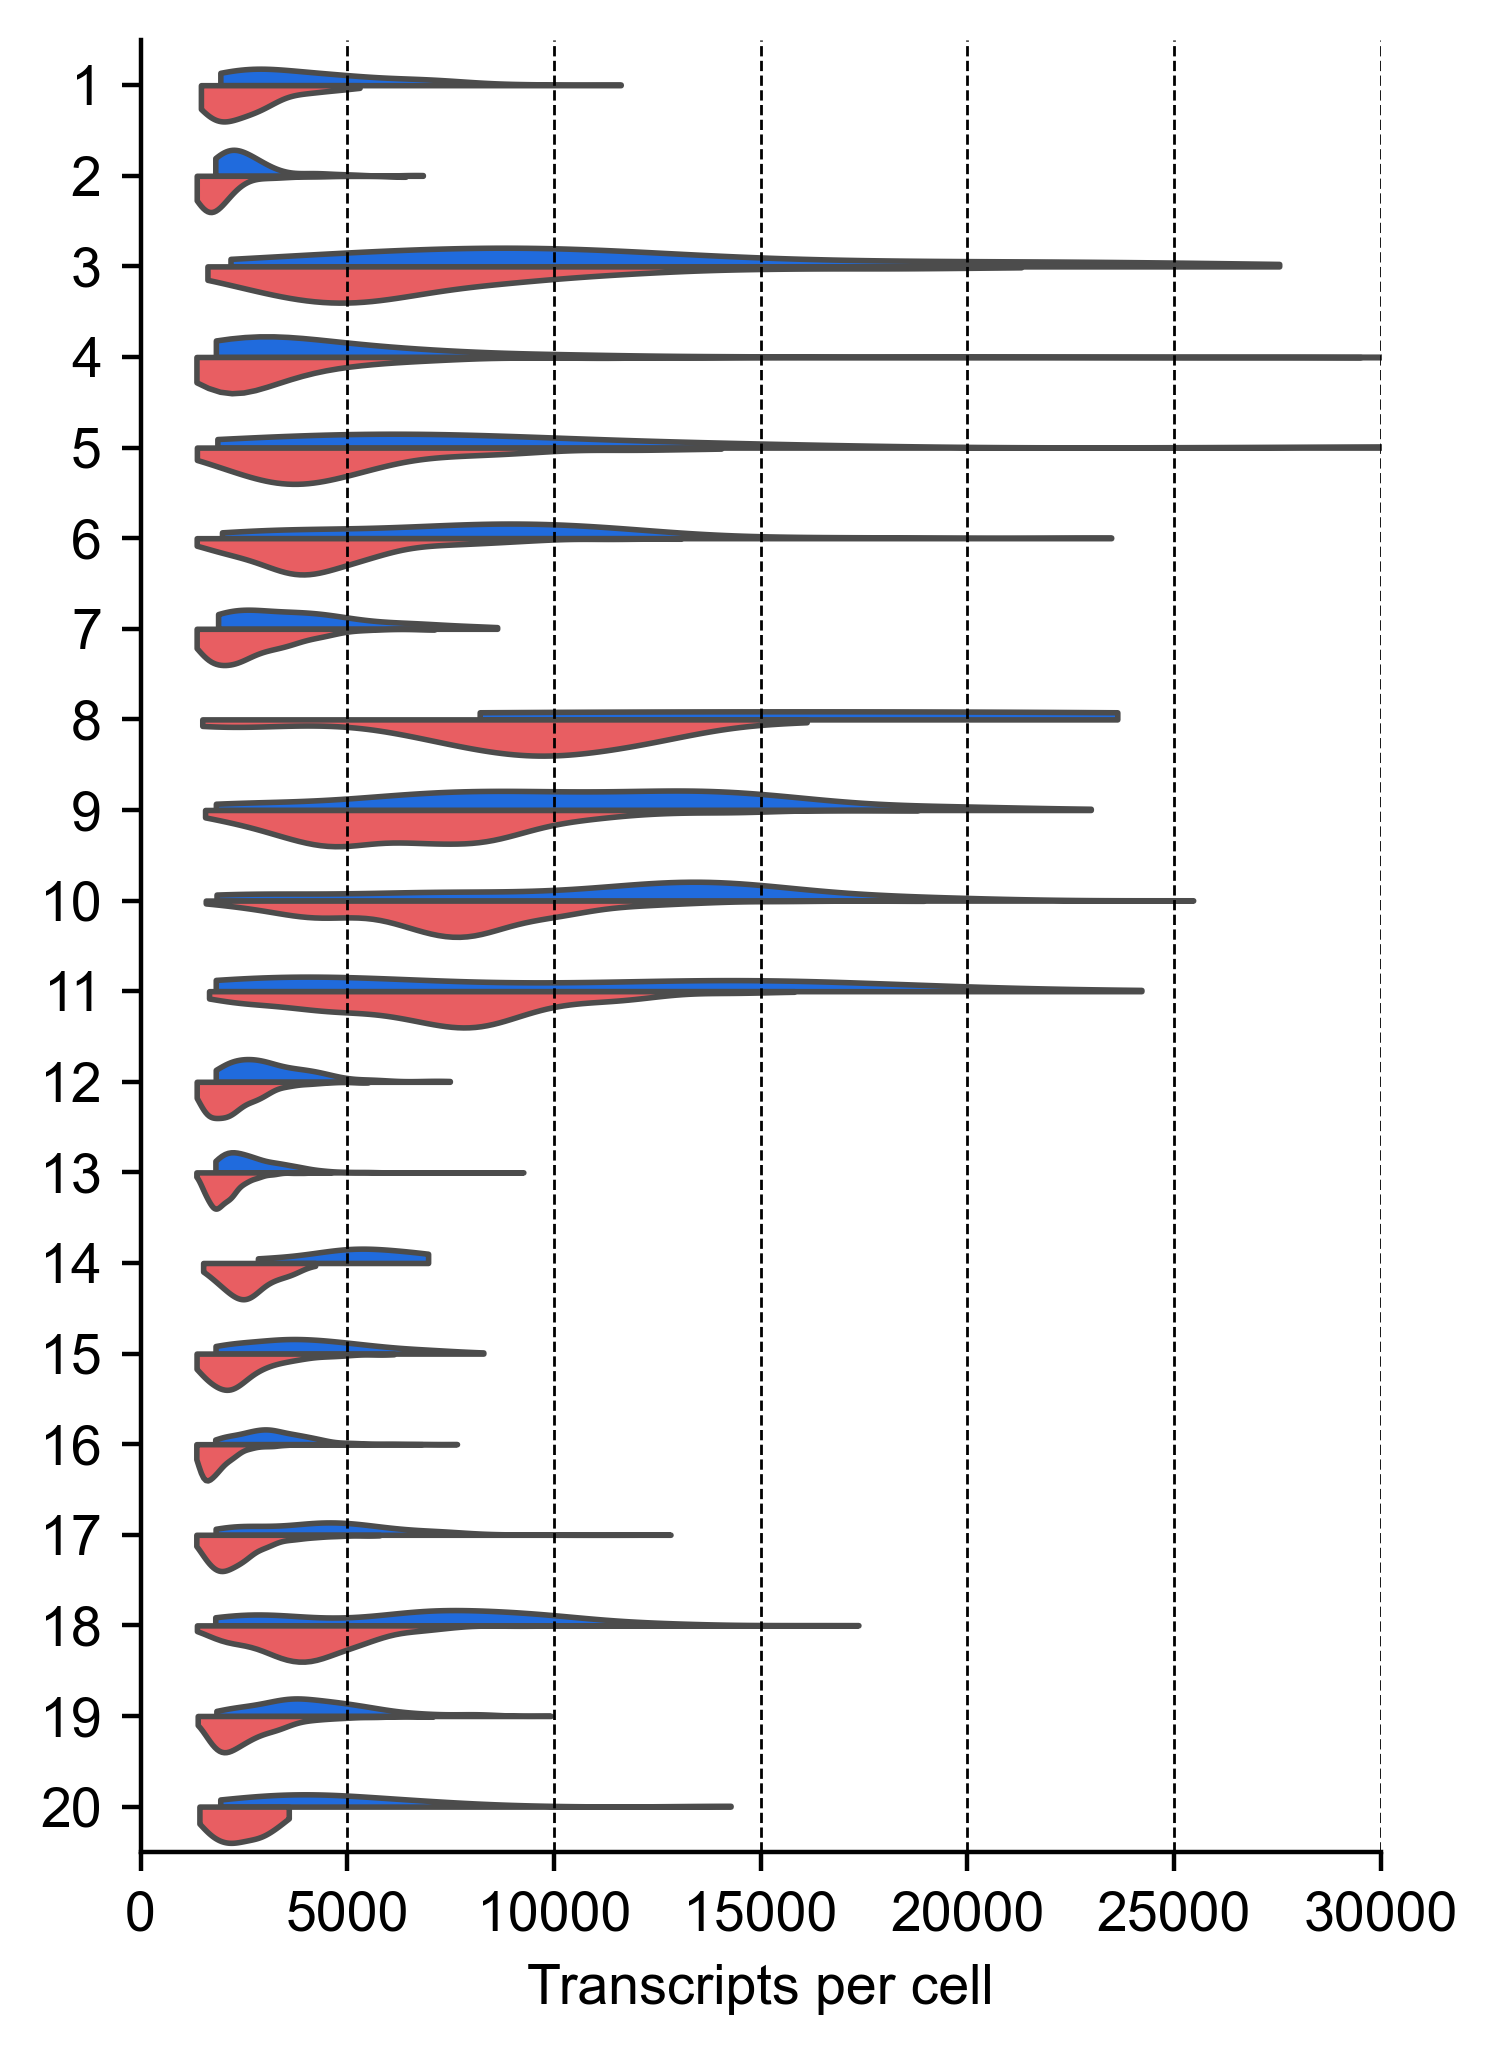

In [370]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.violinplot(
    data=umis, 
    orient="horizontal", 
    y="cluster", x="total_counts",
    hue="background", 
    inner=None,
    cut=0,
    split=True,
    linewidth=1,
    palette=sns.xkcd_palette(["bright blue", "light red"]), zorder=10
)
ax.get_children()[-2].remove()
ax.grid(axis="x", zorder=-10, ls="--", color="k", lw=0.5)
ax.set_xlabel("Transcripts per cell")
ax.set_ylabel("")
sns.despine(fig, ax)
ax.set_xlim(0, 30000)
save_figure(fig, "panel_S1D")

In [278]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
def classify(adata, n_classes, genes, name="global", cluster_key="leiden"):
    mixture = BayesianGaussianMixture(n_components=n_classes, random_state=0)
    X = adata[:, genes].X.toarray()
    
    mixture.fit(X)
    y = mixture.predict(X)
    
    k1 = f"classification_{name}_loglikelihood"
    adata.obs[k1] = 0
    for g, inds in adata.obs.groupby(cluster_key).groups.items():
        inds = adata.obs_names.isin(inds)
        score = mixture.score(X[inds, :])
        adata.obs.loc[inds, k1] = score
    int_key = f"classification_{name}_int"
    int_cluster_key = f"classification_{name}_cluster_int"
    adata.obs[int_key] = y
    adata.obs[int_cluster_key] = adata.obs.groupby(
        cluster_key
    )[int_key].transform(np.median).round().astype(int).astype("category")
    return mixture

In [279]:
neuronal_vs_nonneuronal_genes = ["Snap25", "Elavl2", "Syp", "Tubb3"]
inhibitory_vs_excitatory_genes = ["Slc32a1", "Slc17a6"]

In [280]:
agg = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-clustered-2020-05-31T11-00-35.h5ad")

In [285]:
neuronal_bcs = agg.obs.classification_global_cluster_int == 0
neurons = agg[neuronal_bcs, :].copy()

In [286]:
nmix = classify(neurons, 3, inhibitory_vs_excitatory_genes)

In [290]:
a, b = nmix.sample(10000)

In [299]:
from matplotlib import cycler

In [300]:
custom_cycler = cycler(color=classification_palette)

Saved to panel_S1E_20200614.pdf


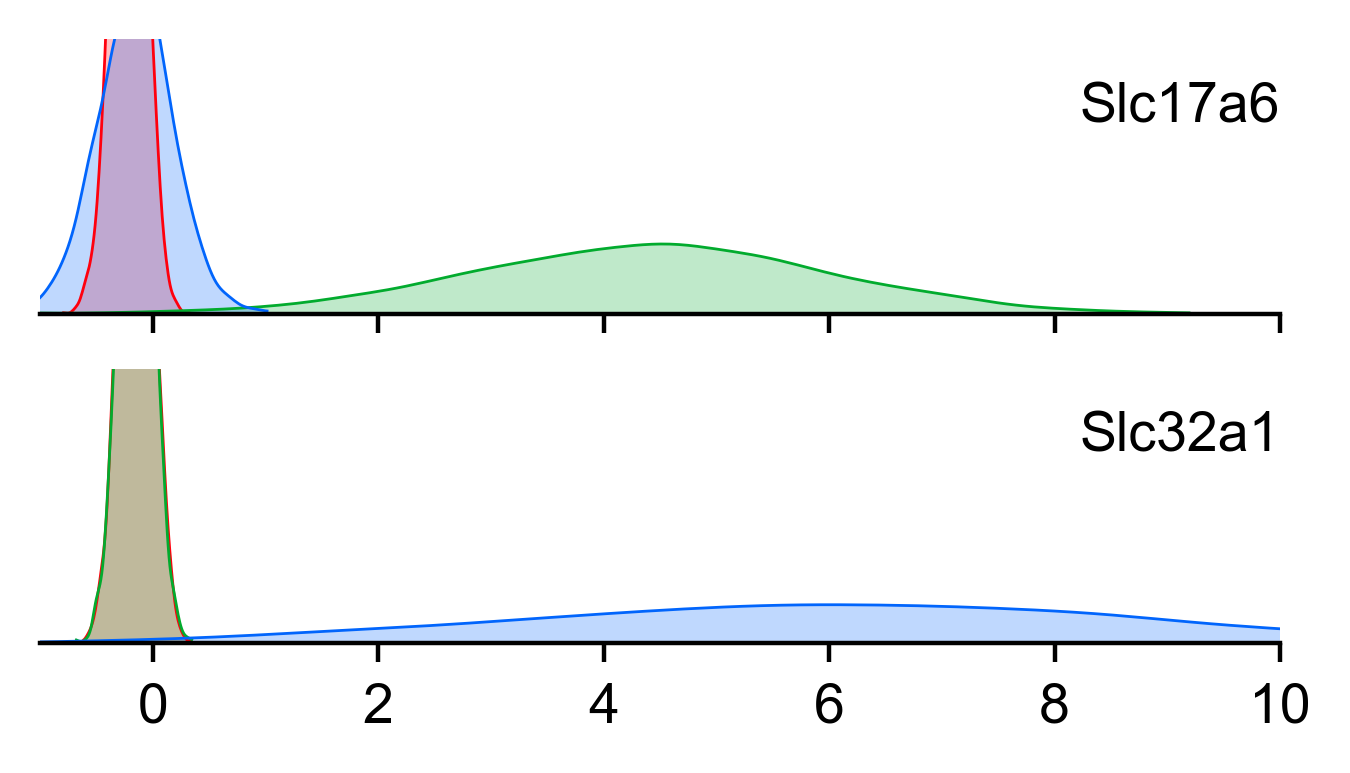

In [308]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,2), sharex=True)
ax1.set_prop_cycle(custom_cycler)
ax2.set_prop_cycle(custom_cycler)
for k in range(3):
    sns.kdeplot(a[b==k,0], shade=True, lw=0.5, cut=0, ax=ax1)
    sns.kdeplot(a[b==k,1], shade=True, lw=0.5, cut=0, ax=ax2)
sns.despine(fig, left=True)
for ax in (ax1, ax2):
    ax.set_yticks([])
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 1)
ax1.text(1, 0.7, "Slc17a6", ha="right", transform=ax1.transAxes)
ax2.text(1, 0.7, "Slc32a1", ha="right", transform=ax2.transAxes)
save_figure(fig, "panel_S1E")

In [321]:
neurons.obsm["X_umap_rotate"] = full[neurons.obs_names,:].obsm["X_umap_rotate"].copy()

In [372]:
neurons.obs["classification_neuronal"] = full[neurons.obs_names,:].obs["classification_neuronal"].copy()

In [322]:
purple_colormap = sns.blend_palette(sns.xkcd_palette(["light grey", "bluish purple"]), as_cmap=True)

[<matplotlib.patches.Rectangle object at 0x2aab4b4eacd0>, <matplotlib.axes._subplots.AxesSubplot object at 0x2aab4b4f2350>, <matplotlib.axes._subplots.AxesSubplot object at 0x2aab4bf6a410>, <matplotlib.axes._subplots.AxesSubplot object at 0x2aab4b627950>, <matplotlib.axes._axes.Axes object at 0x2aab491c9610>]
Saved to panel_S1F_20200614.pdf


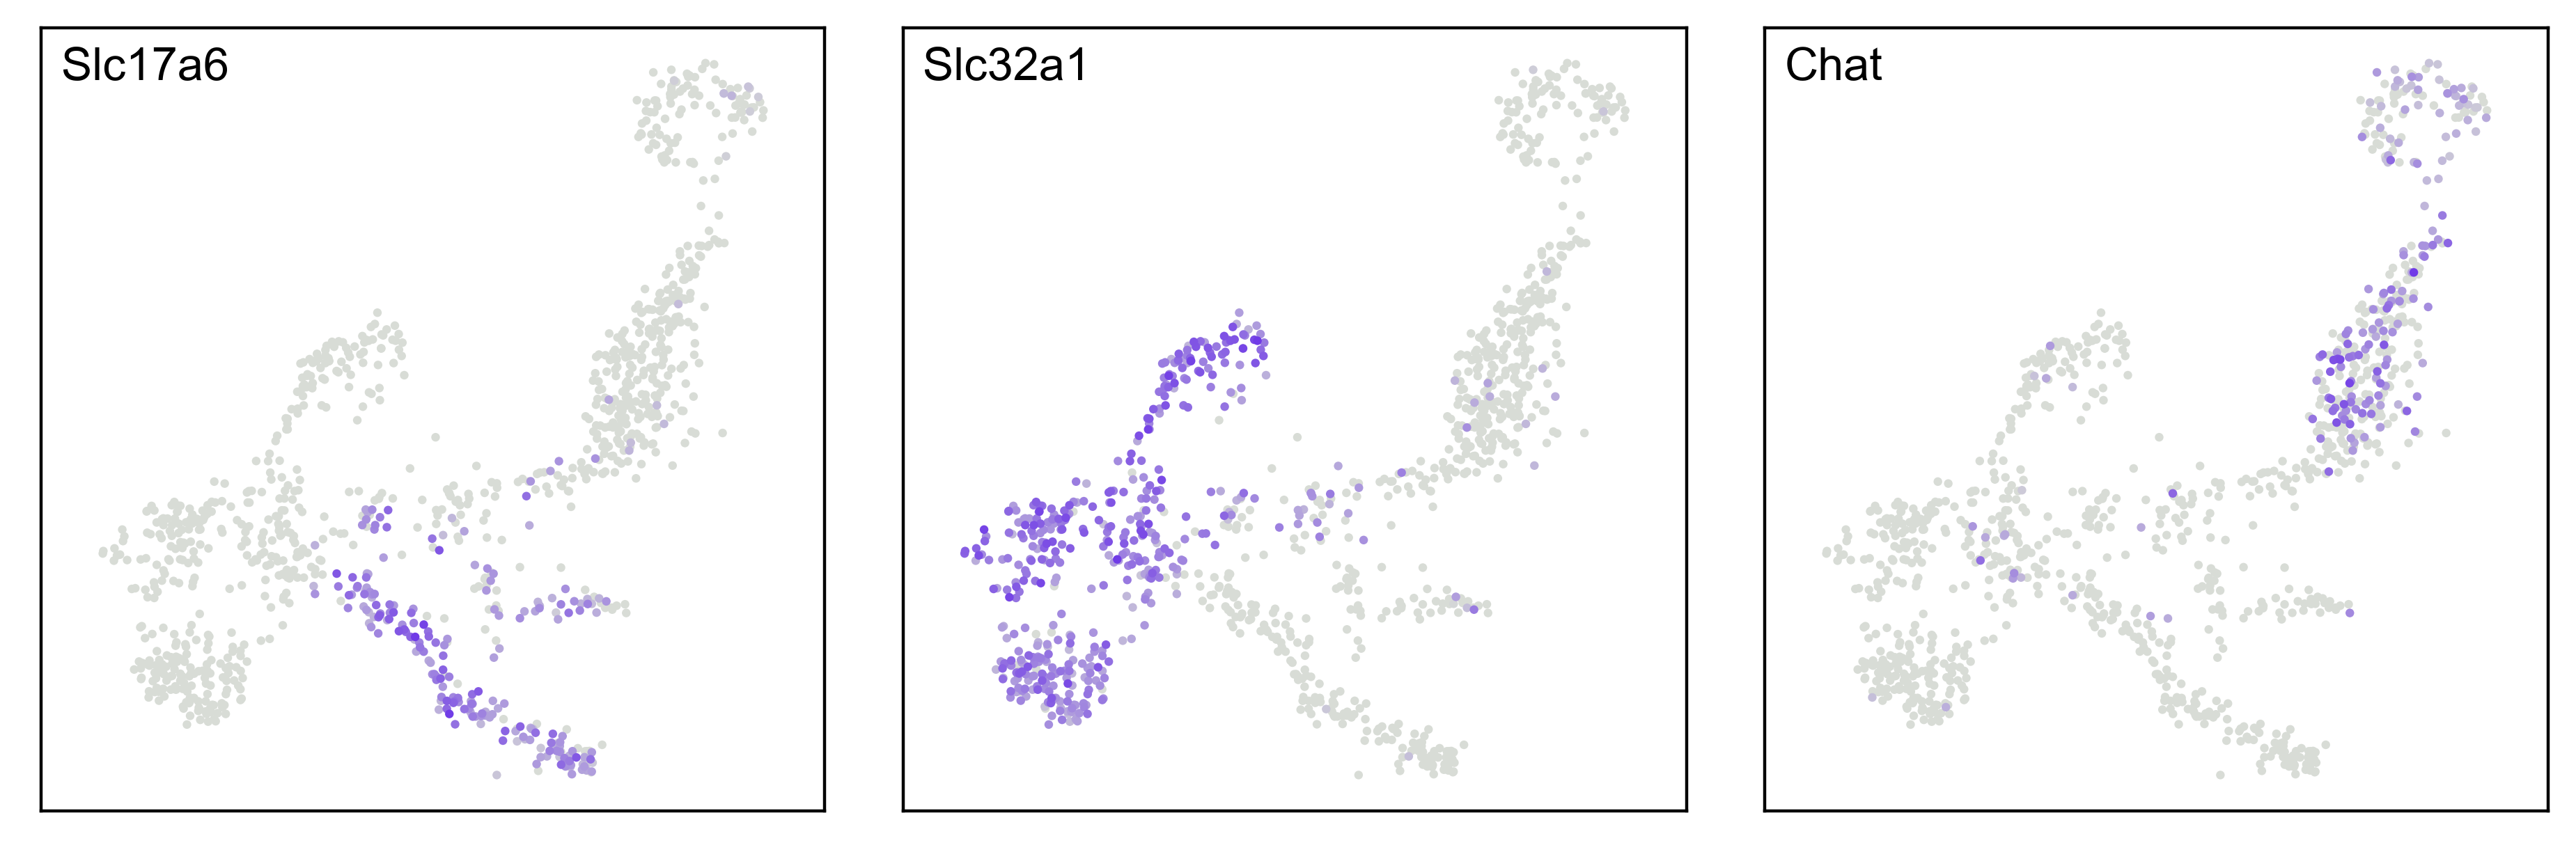

In [362]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
sc.pl.scatter(
    neurons, basis="umap_rotate", color="Slc17a6", size=20,
    ax=axs[0], show=False, title="",
    color_map=purple_colormap,
)
sc.pl.scatter(
    neurons, basis="umap_rotate", color="Slc32a1", size=20,
    ax=axs[1], show=False, title="",
    color_map=purple_colormap,
)
sc.pl.scatter(
    neurons, basis="umap_rotate", color="Chat", size=20,
    ax=axs[2], show=False, title="",
    color_map=purple_colormap,
)
for ax, text in zip(axs, ("Slc17a6", "Slc32a1", "Chat")):
    ax.text(0.025, 0.975, text, ha="left", va="top", fontsize="large", transform=ax.transAxes)
"""
leg = ax3.legend(
    handles=[
        ax.scatter([], [], color=color, marker=[(1,0.5), (-1, 0.5), (-1, -0.5), (1, -0.5)]) 
        for color in sc.pl.palettes.default_20
    ], 
    labels=full.obs.cluster.cat.categories.tolist(),
    ncol=1, frameon=False, bbox_to_anchor=(1, 0.5), loc="center left", 
    handletextpad=0, labelspacing=0, markerscale=2
)
"""
for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")

fix_aspect_scatter_with_cbar(fig)
fig.subplots_adjust(wspace=0.1)
axx = fig.get_children()[-1]
axx.remove()
save_figure(fig, "panel_S1F")

Saved to panel_S1G_20200614.pdf


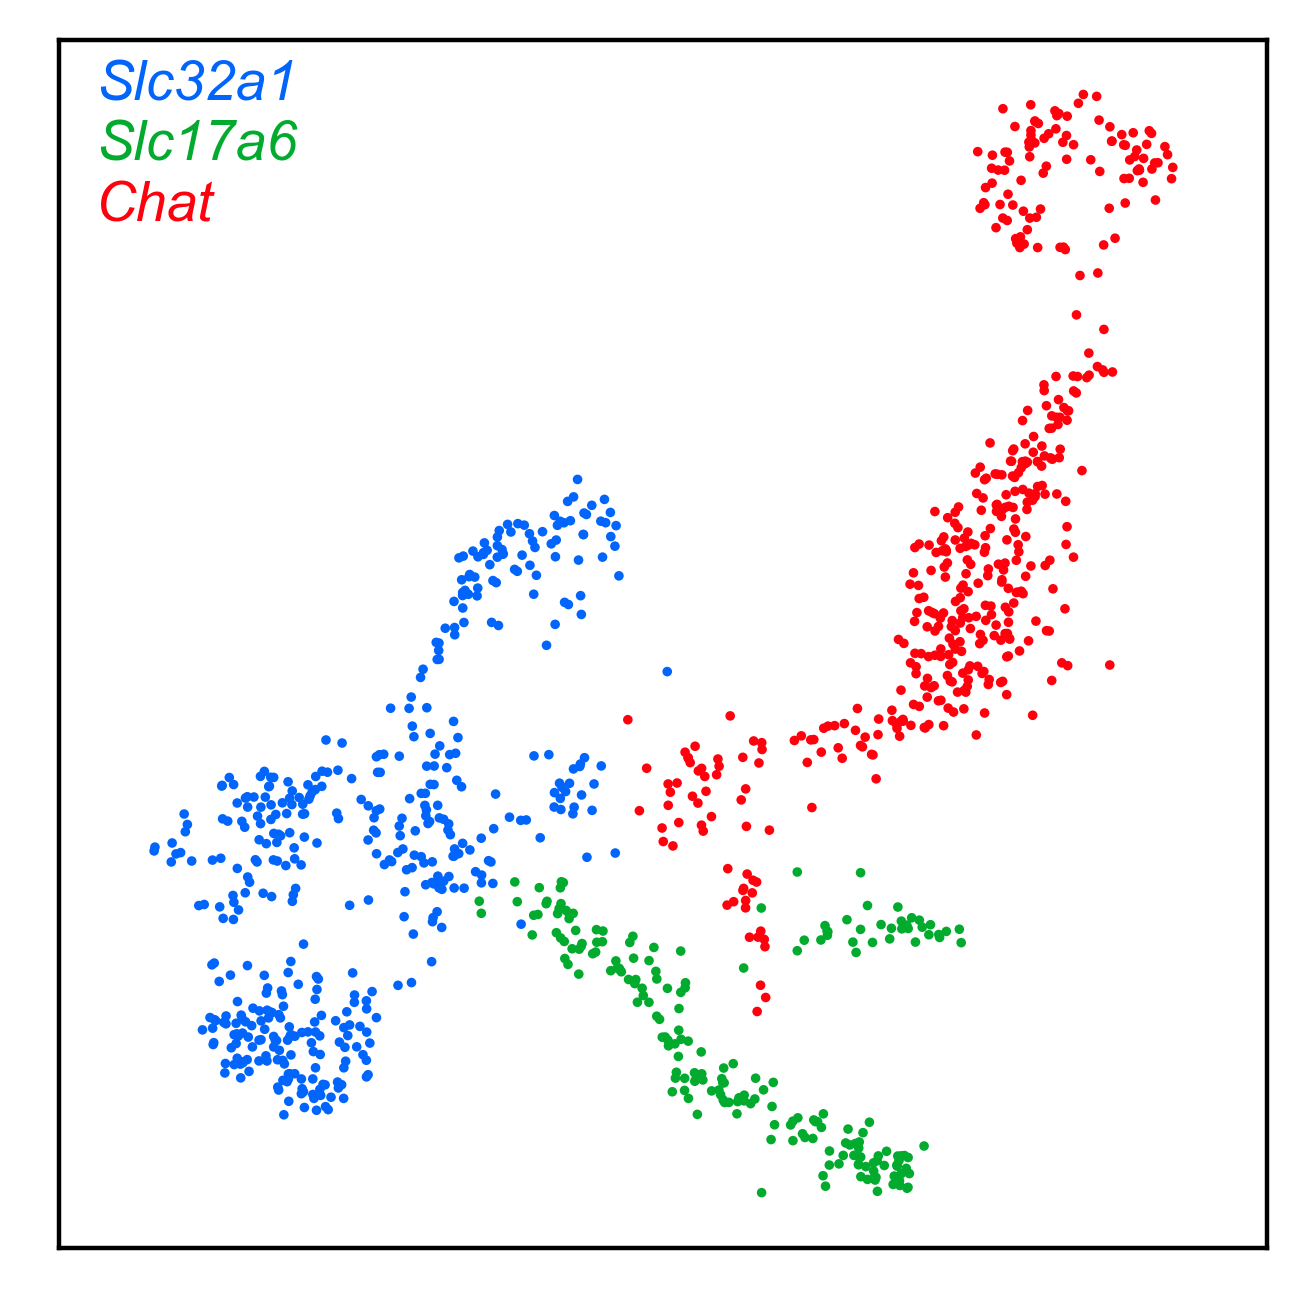

In [376]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.scatter(
    neurons, basis="umap_rotate", color="classification_neuronal", size=12,
    ax=ax, show=False, 
    palette=classification_palette,
    title="", legend_loc="none",
)
ax.set_xlabel("")
ax.set_ylabel("")
for k, (label, color) in enumerate(zip(("Chat", "Slc17a6", "Slc32a1"), classification_palette)):
    ax.text(
        0.03, 0.85+(k*0.05), label, 
        color=color if k < 3 else "0.6", 
        fontdict=dict([("style", "italic" if k < 3 else "normal")]), 
        transform=ax.transAxes, ha="left",
    )
fix_aspect_scatter_with_legend(fig)
save_figure(fig, "panel_S1G")

In [383]:
agg.obs_keys()

['library',
 'log1p_n_genes_by_counts',
 'log1p_total_counts',
 'log1p_total_counts_cell_cycle',
 'log1p_total_counts_hemoglobin',
 'log1p_total_counts_mitochondrial',
 'log1p_total_counts_ribosomal',
 'log1p_total_counts_sex_linked',
 'log1p_total_counts_stress_response',
 'n_genes',
 'n_genes_by_counts',
 'pct_counts_cell_cycle',
 'pct_counts_hemoglobin',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'pct_counts_in_top_50_genes',
 'pct_counts_mitochondrial',
 'pct_counts_ribosomal',
 'pct_counts_sex_linked',
 'pct_counts_stress_response',
 'scrublet_putative_doublet',
 'scrublet_score',
 'sequencing_saturation',
 'total_counts',
 'total_counts_cell_cycle',
 'total_counts_hemoglobin',
 'total_counts_mitochondrial',
 'total_counts_ribosomal',
 'total_counts_sex_linked',
 'total_counts_stress_response',
 'library_id',
 'sample_name',
 'background',
 'leiden',
 'visible_doublet',
 'cluster',
 'classification_global_loglikelihood',
 'clas

In [385]:
agg.obs.groupby("classification_global_cluster_int").total_counts.agg(np.median)

classification_global_cluster_int
0    3988.0
1    2630.5
Name: total_counts, dtype: float32

In [387]:
agg.obs.groupby("classification_global_cluster_int").n_genes_by_counts.agg(np.median)

classification_global_cluster_int
0    2109.5
1    1329.0
Name: n_genes_by_counts, dtype: float64

In [388]:
agg.obs.groupby("classification_global_cluster_int").size()

classification_global_cluster_int
0     1134
1    10676
dtype: int64

In [389]:
10676 / 11810

0.9039796782387807

In [390]:
agg.obs.groupby("classification_neuronal_cluster_int").total_counts.agg(np.median)

classification_neuronal_cluster_int
0     3021.0
1     4439.0
2     4586.5
-1    2630.5
Name: total_counts, dtype: float32